Neural Probabilistic Language Model (NLPM) vise à créer un modèle linguistique en utilisant les particularités des réseaux de neurones.

2003 : Bengio propose une architecture qui permet d'apprendre une représentation distribuée de mots et ainsi résoudre la malédiction de la dimensionalité : une séquence de mots sur laquelle le modèle sera testé est susceptible d'être différente de toutes les séquences de mots observées au cours de la formation.

Ceci en apprenant une représentation distribuée des mots qui permet à chaque phrase d'apprentissage d'informer le modèle sur un nombre exponentiel de phrases sémantiquement voisines.  Le modèle apprend simultanément :
- représentation distribuée pour chaque mot
- la fonction de probabilité pour les séquences de mots, exprimée en termes de ces représentations.

# **Objectif**

Notre tâche consiste à créer un NPLM à l'aide de l'architecture proposée, puis à l'utiliser pour calculer les similitudes entre certains mots.

Pour ce faire, utilisation de Brown Corpus fourni par NLTK qui donnera plusieurs paragraphes pour l'entraînement et le réglage du modèle. Après entraînement, calcul des similitudes entre les mots suivants :
- computer et keyboard (doivent être similaires)
- dog et cat (doivent être similaires)
- dog et car (pas de similarité)
- cat et keyboard (pas de similarité)

Similarité = probabilité que ces mots se retrouvent l'un à côté de l'autre / dans le même contexte.

## Chargement de Brown Corpus

In [2]:
import nltk
import csv
from nltk.corpus import brown
from nltk.corpus import wordnet

nltk.download('brown')
nltk.download('wordnet')

len(brown.paras())

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


15667

15667 paragraphes à disposition

## Création des ensembles d'entraînement et de développement

Comme nous allons construire un modèle de langage neuronal à trigrammes (= suite de mots), l'étape suivante consiste à collecter des trigrammes pour construire nos données d'apprentissage.

Dans un modèle de langage neuronal à trigrammes, par exemple si nous avons le trigramme « la vache mange de l'herbe », l'entrée du modèle est constituée des deux premiers termes d'un trigramme (la vache et mange), et l'objectif du modèle de langage est de prédire le dernier terme du trigramme (l'herbe).

Les 12 000 premiers paragraphes serviront de données d'entraînement, et les 3 000+ restants seront utilisés pour le développement. Lors de la construction des données de formation et de développement, mise en correspondance des mots et des identifiants. Tous les mots qui ne figurent pas dans le vocabulaire doivent être associés à l'identifiant spécial <UNK>.

Exemple : étant donné la phrase « a big fat hungry cow. », créer les exemples de formation suivants :

input       |  target

---

a, big      |  fat

big, fat    |  hungry

fat, hungry |  cow

hungry, cow |  .

\\

Création du vocabulaire comme vu ci-dessus. Ajout au vocabulaire des mots dont la fréquence est >= 5.

In [3]:
num_train = 12000
UNK_symbol = "<UNK>"
vocab = set([UNK_symbol])

#création de brown corpus avec tous les mots
#pas de préprocess, juste les minuscules
brown_corpus_train = []
for idx, paragraph in enumerate(brown.paras()):
  if idx == num_train:
    break
  words = []
  for sentence in paragraph:
    for word in sentence:
      words.append(word.lower())
  brown_corpus_train.append(words)

#création d'une fréquence de termes des mots
words_term_frequency = {}
for doc in brown_corpus_train:
  for word in doc:
    #calcul de la fréquence des termes
    words_term_frequency[word] = words_term_frequency.get(word, 0) + 1

#création du vocab
for doc in brown_corpus_train:
  for word in doc:
    if words_term_frequency.get(word, 0) >= 5:
      vocab.add(word)

print(len(vocab))

12681


Création des ensembles d'entraînement et de développement. Remplacement des mots par leur index correspondant dans le vocabulaire afin qu'ils puissent être introduits facilement dans le réseau de neurones.

In [5]:
import numpy as np

X_train = []
y_train = []
X_dev = []
y_dev = []

#création d'une correspondance entre les mots et id
mapping = {}
for idx, word in enumerate(vocab):
  mapping[word] = idx

#fonction pour recup l'id d'un mot donné
#retourne <UNK> id si pas trouvé
def get_id_of_word(word):
  unknown_word_id = mapping['<UNK>']
  return mapping.get(word, unknown_word_id)

#création des ensembles d'entraînement et de dev
for idx, paragraph in enumerate(brown.paras()):
  for sentence in paragraph:
    for i, word in enumerate(sentence):
      if i+2 >= len(sentence):
        #limite de la phrase atteinte
        #ignorer une phrase de moins de 3 mots
        break
      #conversion du mot vers l'id
      X_extract = [get_id_of_word(word.lower()), get_id_of_word(sentence[i+1].lower())]
      y_extract = [get_id_of_word(sentence[i+2].lower())]
      if idx < num_train:
        X_train.append(X_extract)
        y_train.append(y_extract)
      else:
        X_dev.append(X_extract)
        y_dev.append(y_extract)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_dev = np.array(X_dev)
y_dev = np.array(y_dev)

print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)

(872823, 2)
(872823, 1)
(174016, 2)
(174016, 1)


## Architecture **NLPM**

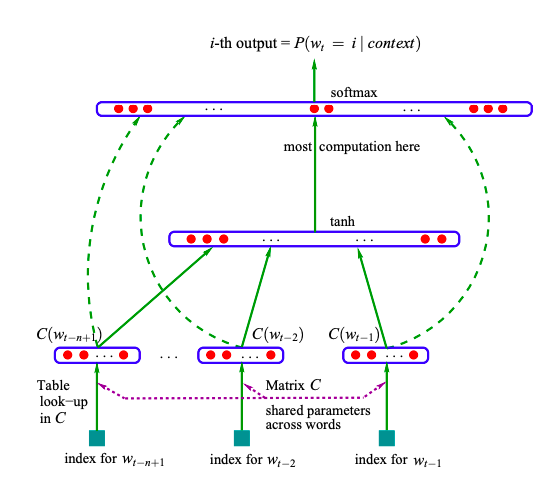

Adapter cette structure au trigramme en ne prenant que deux mots en entrée et en prédisant le mot suivant :

$x' = e(x_1) ⊕ e(x_2)$

$h = tanh(W_1 x' + b)$

$y = softmax(W_2 h)$

où ⊕ est l'opérateur de concaténation, $x_1$ et $x_2$ sont les mots d'entrée, $e$ est la fonction d'intégration, et $y$ le mot cible.

Maintenant, si on a un réseau neuronal avec 100 états cachés et 200 vecteurs de taille pour chaque mot avec un vocabulaire de 12681 :

embedding_matrix = (12681 x 200)

e(x1) = (1 x 200)

e(x2) = (1 x 200)

x' = (1 x 200) concat (1 x 200) = (1 x 400)

W1 = (100 x 400)

b = (1 x 100)

h = tanh(W1 x' + b) = (1 x 100)

W2 = (12681 x 100)

y = softmax(W2 h) = (1 x 12681)

In [7]:
import torch
import multiprocessing
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time

class TrigramNNModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_size, h):
    super(TrigramNNModel, self).__init__()
    self.context_size = context_size
    self.embedding_dim = embedding_dim
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.linear1 = nn.Linear(context_size * embedding_dim, h)
    self.linear2 = nn.Linear(h, vocab_size, bias = False)

  def forward(self, inputs):
    #calcul de x' : concatenation des embeddings x1 et x2
    embeds = self.embeddings(inputs).view(-1, self.context_size * self.embedding_dim)
    #calcul de h : tanh(W1.x' + b)
    out = torch.tanh(self.linear1(embeds))
    #calcul de W2.h
    out = self.linear2(out)
    #calcul de y : log_softmax(W2.h)
    log_probs = F.log_softmax(out, dim=1)
    #retourne probabilités logarithmiques
    #BATCH_SIZE x len(vocab)
    return log_probs

## Entraînement et sauvegarde du modèle Pytorch avec accélération GPU

Dans un premier temps, créer un dataloader pour les données d'entraînement et de dév.

On utilisera 100 unités cachées avec des vecteurs de 200 mots, et 256 comme taille de lot (batch size) pour le dataloader.

In [11]:
#création des paramètres
gpu = 0

#taille des vecteurs de mots
EMBEDDING_DIM = 200
CONTEXT_SIZE = 2
BATCH_SIZE = 256

#unités cachées
H = 100
torch.manual_seed(13013)

#check si gpu est disponible
# If CUDA is not available, default to CPU. This line was changed to fix the error
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
available_workers = multiprocessing.cpu_count()

print("Creating training and dev dataloaders with {} batch size".format(BATCH_SIZE))
train_set = np.concatenate((X_train, y_train), axis = 1)
dev_set = np.concatenate((X_dev, y_dev), axis = 1)
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, num_workers = available_workers)
dev_loader = DataLoader(dev_set, batch_size = BATCH_SIZE, num_workers = available_workers)

Creating training and dev dataloaders with 256 batch size


In [12]:
#obtenir la précision des probabilités logarithmiques
def get_accuracy_log(log_probs, labels):
  probs = torch.exp(log_probs)
  predicted_label = torch.argmax(probs, dim = 1)
  acc = (predicted_label == labels).float().mean()
  return acc

#évaluation du modèle sur les données de dev
def evaluate(model, criterion, dataloader, gpu):
  model.eval()
  mean_acc, mean_loss = 0, 0
  count = 0

  with torch.no_grad():
    dev_st = time.time()
    for it, data_tensor in enumerate(dataloader):
      context_tensor = data_tensor[:,0:2]
      target_tensor = data_tensor[:,2]
      context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)
      log_probs = model(context_tensor)
      mean_loss += criterion(log_probs, target_tensor).item()
      mean_acc += get_accuracy_log(log_probs, target_tensor)
      count += 1
      if it % 500 == 0:
        print("Dev iteration {} complete. Mean Loss : {}; Mean Acc : {}; Time taken (s) : {}".format(it, mean_loss / count, mean_acc / count, (time.time() - dev_st)))
        dev_st = time.time()
  return mean_acc / count, mean_loss / count

In [14]:
#utilisation de la perte log-likelihood négative
loss_function = nn.NLLLoss()

#création du modèle
model = TrigramNNModel(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE, H)

#chargement du modèle sur le gpu
model.to(device)

#utilisation de l'optimiser ADAM
optimizer = optim.Adam(model.parameters(), lr = 2e-3)

#-----------------ENTRAINEMENT DU MODELE----------------
best_acc = 0
best_model_path = None

for epoch in range(5):
  st = time.time()
  print("\n Training model Epoch : {}".format(epoch+1))
  for it, data_tensor in enumerate(train_loader):
    context_tensor = data_tensor[:,0:2]
    target_tensor = data_tensor[:,2]

    context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)

    #annulation des gradients de l'ancienne distance
    model.zero_grad()

    #obtention des proba log sur les mots suivants
    log_probs = model(context_tensor)

    #calcul de la précision actuelle
    acc = get_accuracy_log(log_probs, target_tensor)

    #calcul de la loss function
    loss = loss_function(log_probs, target_tensor)

    #passage en arrière et maj du gradient
    loss.backward()
    optimizer.step()

    if it % 500 == 0:
      print("Iteration {} complete. Loss : {}; Accuracy : {}; Time taken (s) : {}".format(it, loss.item(), acc, (time.time() - st)))
      st = time.time()

  print("\n Evaluating model on dev data")
  dev_acc, dev_loss = evaluate(model, loss_function, dev_loader, gpu)
  print("Epoch {} complete! Dev accuracy : {}; Dev Loss : {}".format(epoch, dev_acc, dev_loss))
  if dev_acc > best_acc:
    print("Best dev accuracy improved from {} to {}, saving model.".format(best_acc, dev_acc))
    best_acc = dev_acc
    #définition du chemin du meilleur modèle
    best_model_path = 'best_model_{}.dat'.format(epoch)
    #sauvegarde du meilleur modèle
    torch.save(model.state_dict(), best_model_path)



 Training model Epoch : 1
Iteration 0 complete. Loss : 9.474194526672363; Accuracy : 0.0; Time taken (s) : 0.5636405944824219
Iteration 500 complete. Loss : 6.25606632232666; Accuracy : 0.14453125; Time taken (s) : 34.56819677352905
Iteration 1000 complete. Loss : 6.112386703491211; Accuracy : 0.140625; Time taken (s) : 32.594919204711914
Iteration 1500 complete. Loss : 6.093239784240723; Accuracy : 0.13671875; Time taken (s) : 32.07721972465515
Iteration 2000 complete. Loss : 5.900447845458984; Accuracy : 0.11328125; Time taken (s) : 32.01151466369629
Iteration 2500 complete. Loss : 6.155505180358887; Accuracy : 0.14453125; Time taken (s) : 32.16296601295471
Iteration 3000 complete. Loss : 5.68014669418335; Accuracy : 0.203125; Time taken (s) : 31.927522659301758

 Evaluating model on dev data
Dev iteration 0 complete. Mean Loss : 5.054906845092773; Mean Acc : 0.19140625; Time taken (s) : 0.09615921974182129
Dev iteration 500 complete. Mean Loss : 5.128794352213542; Mean Acc : 0.1683

## Calcul des similitudes de mots grâce au modèle

In [16]:
best_model = TrigramNNModel(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE, H)
best_model.load_state_dict(torch.load(best_model_path, weights_only=True))
best_model.to(device)

cos = nn.CosineSimilarity(dim=0)

lm_simili = {}

#paires de mots pour calculer la similarité
words = {('computer', 'keyboard'), ('cat', 'dog'), ('dog', 'car'), ('keyboard', 'cat')}

#calcul similarités LM en utilisant la similarité cosinus
for word_pairs in words:
  w1 = word_pairs[0]
  w2 = word_pairs[1]
  words_tensor = torch.LongTensor([get_id_of_word(w1), get_id_of_word(w2)])
  words_tensor = words_tensor.to(device)
  #obtention du mot à partir du meilleur modèle
  words_embeds = best_model.embeddings(words_tensor)
  #calcul similarité cosinus entre vecteurs de mots
  sim = cos(words_embeds[0], words_embeds[1])
  lm_simili[word_pairs] = sim.item()
print(lm_simili)


{('cat', 'dog'): 0.02588968724012375, ('dog', 'car'): -0.005435522645711899, ('keyboard', 'cat'): -0.04272951930761337, ('computer', 'keyboard'): 0.07996205240488052}


Le résultat suggère que (keyboard, computer) et (cat, dog) sont plus similaires du point de vue du contexte ou de la proba de co-occurence que (keyboard, cat) et (dog, car).